In [156]:
import os
import pandas as pd

import numpy as np
import random

from matplotlib import pyplot as plt
import cv2

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Rescaling

In [14]:
#loading the EMNIST DATASET provided by https://www.kaggle.com/datasets/crawford/emnist
dataset_path = 'EMNIST/'
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
num_classes = 47
print(os.listdir(dataset_path))

['emnist-balanced-mapping.txt', 'emnist-balanced-test.csv', 'emnist-balanced-train.csv', 'emnist-byclass-mapping.txt', 'emnist-byclass-test.csv', 'emnist-byclass-train.csv', 'emnist-bymerge-mapping.txt', 'emnist-bymerge-test.csv', 'emnist-bymerge-train.csv', 'emnist-digits-mapping.txt', 'emnist-digits-test.csv', 'emnist-digits-train.csv', 'emnist-letters-mapping.txt', 'emnist-letters-test.csv', 'emnist-letters-train.csv', 'emnist-mnist-mapping.txt', 'emnist-mnist-test.csv', 'emnist-mnist-train.csv', 'emnist_source_files']


In [29]:
#reading data from file
train = pd.read_csv(dataset_path+'emnist-balanced-train.csv')
test = pd.read_csv(dataset_path+'emnist-balanced-test.csv')

In [100]:
#labels
t_train = train.reindex(columns=train.columns[:1])
t_test = test.reindex(columns=test.columns[:1])

#images
x_train = train.reindex(columns=train.columns[1:])
x_test = test.reindex(columns=test.columns[1:])

In [101]:
print(x_train.shape)
print(x_test.shape)

(112799, 784)
(18799, 784)


In [102]:
#reshape image in 2 dimensions (height = 28px, width = 28px)
t_train = t_train.to_numpy().reshape(-1)
t_test = t_test.to_numpy().reshape(-1)

#transpose data since dataset is rotated
x_train = np.transpose(x_train.values.reshape(-1,28,28).astype(np.uint8), axes=[0,2,1])
x_test = np.transpose(x_test.values.reshape(-1,28,28).astype(np.uint8), axes=[0,2,1])

In [103]:
print(x_train.shape)
print(x_test.shape)

(112799, 28, 28)
(18799, 28, 28)


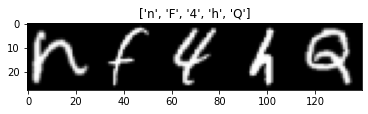

In [131]:
#showing portion of dataset after reshaping
_range = range(1,5+1)
plt.imshow(np.hstack(x_train[_range]), cmap='gray')
plt.title([class_mapping[i] for i in list(t_train[_range].astype(int))])
plt.show()

Text(0.5, 1.0, 'a')

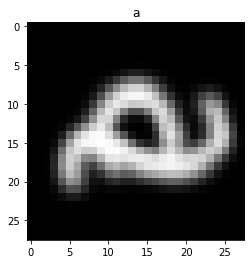

In [126]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  return cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

#rotate, rescales and resizes image
def rrrIMG(image):
    scale = random.choice(np.arange(60, 100.1, 0.01)) #choses scale from 60% to 100%
    new_dim = tuple((np.array(image.shape)*scale/100).astype('int'))
    resized = cv2.resize(image, new_dim, interpolation = cv2.INTER_AREA)
    
    angle = random.choice(np.arange(-90, 90, 0.01))
    rotated = rotate_image(resized, angle)
    
    return cv2.resize(rotated, (28,28))
plt.imshow(rrrIMG(x_train[0]),cmap='gray')
plt.title(class_mapping[t_train[0]])

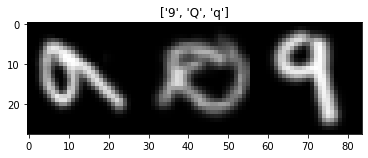

In [139]:
#rescale and rotate images at random to allow code to be covariant to rotation and scaling and augment the dataset
data_train = []
label_train = []
for i in range(len(t_train)):
    for j in range(5):
        data_train.append(rrrIMG(x_train[i]))
        label_train.append(t_train[i])

data_test = []
label_test = []
for i in range(len(t_test)):
    data_test.append(rrrIMG(x_test[i]))
    label_test.append(t_test[i])        

plt.imshow(np.hstack(data_test[0:4]), cmap='gray')
plt.title([class_mapping[i] for i in list(label_test[0:4])])
plt.show()

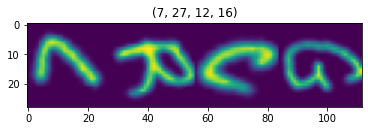

In [140]:
#shuffle training set so when training in batches it doesn't have similar dataset caused by data augmentation
for i in range(100):
    c = list(zip(data_train, label_train))
    random.shuffle(c)
    data_train, label_train = zip(*c)

    c = list(zip(data_test, label_test))
    random.shuffle(c)
    data_test, label_test = zip(*c)

plt.imshow(np.hstack(data_train[0:4]))
plt.title(label_train[0:4])
plt.show()

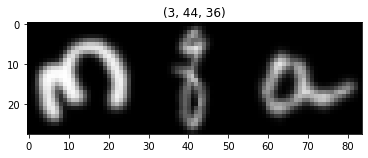

In [141]:
#showing portion of dataset after augmentation
plt.imshow(np.hstack(data_test[0:4]),cmap='gray')
plt.title(label_test[0:4])
plt.show()

In [153]:
#one-hot encoding labels
y_train = np_utils.to_categorical(label_train, num_classes)
y_test = np_utils.to_categorical(label_test, num_classes)
print("Shape before: ", np.shape(label_train))
print("Shape after: ", y_train.shape)

Shape before:  (563995,)
Shape after:  (563995, 47)


In [155]:
#spliting and organizing arrays to work with keras model
xx_train, x_val, y_train, y_val = train_test_split(data_train, y_train, test_size=0.2, random_state=400196693)
xx_train = tf.expand_dims(np.array(xx_train,dtype='float32'),axis=3)
x_val = tf.expand_dims(np.array(x_val,dtype='float32'),axis=3)
xx_test = tf.expand_dims(np.array(data_test,dtype='float32'),axis=3)

In [183]:
tf.random.set_seed(400196693)

model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='softmax'))

# compile model
model.compile(optimizer="SGD", loss='binary_crossentropy', metrics=['accuracy'])

In [184]:
epoch = 60
model.fit(xx_train, y_train, batch_size=128, epochs=epoch, validation_data=(x_val, y_val))

Epoch 1/60
3525/3525 [==============================] - 178s 50ms/step - loss: 0.1149 - accuracy: 0.0427 - val_loss: 0.1041 - val_accuracy: 0.0685
Epoch 2/60
3525/3525 [==============================] - 177s 50ms/step - loss: 0.1017 - accuracy: 0.0943 - val_loss: 0.0995 - val_accuracy: 0.1152
Epoch 3/60
3525/3525 [==============================] - 180s 51ms/step - loss: 0.0977 - accuracy: 0.1324 - val_loss: 0.0959 - val_accuracy: 0.1502
Epoch 4/60
3525/3525 [==============================] - 175s 50ms/step - loss: 0.0942 - accuracy: 0.1640 - val_loss: 0.0926 - val_accuracy: 0.1779
Epoch 5/60
3525/3525 [==============================] - 184s 52ms/step - loss: 0.0912 - accuracy: 0.1890 - val_loss: 0.0898 - val_accuracy: 0.2013
Epoch 6/60
3525/3525 [==============================] - 177s 50ms/step - loss: 0.0886 - accuracy: 0.2108 - val_loss: 0.0873 - val_accuracy: 0.2219
Epoch 7/60
3525/3525 [==============================] - 181s 51ms/step - loss: 0.0862 - accuracy: 0.2297 - val_loss: 0

3525/3525 [==============================] - 156s 44ms/step - loss: 0.0452 - accuracy: 0.6376 - val_loss: 0.0453 - val_accuracy: 0.6366
Epoch 57/60
3525/3525 [==============================] - 155s 44ms/step - loss: 0.0449 - accuracy: 0.6400 - val_loss: 0.0450 - val_accuracy: 0.6379
Epoch 58/60
3525/3525 [==============================] - 155s 44ms/step - loss: 0.0447 - accuracy: 0.6422 - val_loss: 0.0448 - val_accuracy: 0.6390
Epoch 59/60
3525/3525 [==============================] - 155s 44ms/step - loss: 0.0445 - accuracy: 0.6444 - val_loss: 0.0446 - val_accuracy: 0.6426
Epoch 60/60
3525/3525 [==============================] - 156s 44ms/step - loss: 0.0442 - accuracy: 0.6464 - val_loss: 0.0443 - val_accuracy: 0.6441


Text(0.5, 1.0, 'Training and Validation Accuracy')

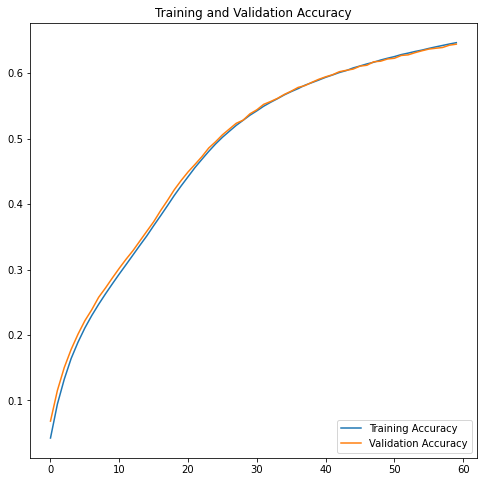

In [185]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
plt.figure(figsize=(8, 8))
plt.plot(range(epoch), acc, label='Training Accuracy')
plt.plot(range(epoch), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [205]:
test_accuracy = model.evaluate(xx_test, y_test, batch_size=128)
version = 4
modelpath = 'Classifiers/charClassifier'+str(version)+'.h5'
model.save(modelpath)
model2 = tf.keras.models.load_model(modelpath)

147/147 [==============================] - 2s 13ms/step - loss: 0.0450 - accuracy: 0.6335


In [201]:
check = np.bitwise_and.reduce(np.bitwise_and.reduce(model.predict([xx_test[:4]])==model2.predict([xx_test[:4]])))
if (not(check)):
    print('ERROR SAVING MODEL')
else:
    print('SAVED MODEL SUCCESSFULLY')

SAVED MODEL SUCCESSFULLY
